# Estimating the compute cost of Prio (with libprio and Spark)

This estimates the price of running Prio to count origins across a Firefox population. In particular, we are interested in estimating the total CPU time across a cluster given the size of the Prio bitvector and the total number of samples taken. These two parameters, `n_data` and `n_rows` respectively, can be multiplied to obtain the volume of data to be processed. The aggregate CPU time is linearly related to the volume of the incoming data.

Given one million samples of ~2500-bit vectors a week, we expect a daily processing job to take 97 CPU hours across all stages of the Prio pipeline.

## Methodology

We collect Spark history metrics on generated data across various population sizes (`n_rows`) and bits of information (`n_data`) using `scripts/test-cli-integration-dataproc`, each run on a single-node `n1-standard-16` cluster. We compute the total time spent for the `verify1`, `verify2`, `aggregate`, and `publish` step for each Prio server. A linear model is fit to determine the compute time given the population size and the bit-vector length. The scenarios are estimated by querying `telemetry.main` for the number of distinct clients over the period of a day.

## Collection

In [1]:
from pyspark.sql import SparkSession, functions as F, Row
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

### Metadata about benchmark runs

In [2]:
@F.udf("string")
def parse_config_path(filename):
    parts = filename.split("/")
    return parts[-2]

run_time = (
    spark.read.json("../data/*/*/dataproc-jobs-list.json", multiLine=True)
    .select("placement.clusterName", "status.stateStartTime")
    .groupBy("clusterName")
    .agg(
        F.min("stateStartTime").alias("start"), 
        F.max("stateStartTime").alias("end")
    )
    .select(
        F.col("clusterName").alias("cluster_id"), 
        (F.unix_timestamp("end")-F.unix_timestamp("start")).alias("job_run_seconds")
    )
)

# dont need num_workers, batch_id, scale in this test
config = (
    spark.read.json("../data/*/config.json", multiLine=True)
    .withColumn("cluster_id", parse_config_path(F.input_file_name()))
    .join(run_time, on="cluster_id")
    .select("machine_type", "cluster_id", "n_rows", "n_data", "job_run_seconds")
    .orderBy("n_rows", "n_data")
)

config.drop("cluster_id").toPandas()

,machine_type,n_rows,n_data,job_run_seconds
0,n1-standard-16,2500,32,346
1,n1-standard-16,2500,64,355
2,n1-standard-16,2500,128,385
3,n1-standard-16,5000,32,340
4,n1-standard-16,5000,64,381
5,n1-standard-16,5000,128,445
6,n1-standard-16,7500,32,370
7,n1-standard-16,7500,64,416
8,n1-standard-16,7500,128,541
9,n1-standard-16,10000,32,385


### Summary of stages with calls to `libprio`

In [3]:
# by file convention, we can extract both the cluster-id and application name for grouping
@F.udf("struct<cluster_id: string, application_name: string>")
def parse_benchmark_path(filename):
    """Parse the spark job history filename for relevant grouping information.
    file:/Users/amiyaguchi/Work/prio-processor/data/test-32-2500-n1-standard-16-0-20200823234848898312/logs/spark-job-history/application_1598251821633_0002
    """
    parts = filename.split("/")
    return dict(cluster_id=parts[-4], application_name=parts[-1])

@F.udf("string")
def sequence_id(application_name):
    return application_name.split("_")[-1]

# spark history logs (used to generate the spark UI)
job_history = (
    spark.read.json("../data/*/logs/spark-job-history/*")
    .drop("sparkPlanInfo")
    .drop("Hadoop Properties")
    .drop("Spark Properties")
    .drop("Properties")
    .drop("Classpath Entries")
    .drop("System Properties")
    .withColumn("filename", F.input_file_name())
)

# parse out the relevant metrics and convert them into reasonable units
# https://spark.apache.org/docs/latest/monitoring.html#executor-task-metrics
task_metrics = (
    job_history
    .where(F.col("Event") == "SparkListenerTaskEnd")
    .withColumn("job_info", parse_benchmark_path("filename"))
    .withColumn("task_info", F.col("Task Info"))
    .withColumn("task_metrics", F.col("Task Metrics"))
    .select("*", "task_metrics.*")
    .select(
        "job_info.*",
        F.col("Task End Reason").getField("Reason").alias("reason"),
        F.col("Stage ID").alias("stage_id"),
        F.col("Stage Attempt ID").alias("stage_attempt_id"),
        F.col("Task Type").alias("task_type"), 
        F.col("task_info").getField("Task ID").alias("task_id"),
        F.col("task_info").getField("Executor ID").alias("executor_id"),
        (F.col("Executor Run Time")/1000).alias("run_seconds"),
        (F.col("Executor CPU Time")/10**9).alias("cpu_seconds"), 
        (F.col("Executor Deserialize Time")/1000).alias("deser_run_seconds"),
        (F.col("Executor Deserialize CPU Time")/10**9).alias("deser_cpu_seconds"),
        F.col("Result Size").alias("result_size"),
    )
    .orderBy("cluster_id", "application_name", "task_id", "executor_id")
)


# aggregate metrics for each job submitted to a cluster by stage
# deser_run_seconds, deser_cpu_seconds
metrics = ["run_seconds", "cpu_seconds", "result_size"]
task_aggregation = (
    task_metrics
    .withColumn("sequence_id", sequence_id("application_name"))
    .where("reason = 'Success'")
    .groupBy("sequence_id", "stage_id", "cluster_id")
    .agg(*[F.round(F.sum(metric), 1).alias(metric) for metric in metrics], 
         F.countDistinct("task_id", "executor_id").alias("task_count"))
    .orderBy("sequence_id", "stage_id", "cluster_id")
)
task_aggregation.cache()

# now we only keep the stage for each sequence with the highest cumulative value
# since this is the stage of interest for scaling
largest_stage = (
    task_aggregation
    .groupBy("sequence_id", "stage_id")
    .agg(F.sum("run_seconds").alias("run_seconds"))
    .withColumn(
        "_rank",
        F.row_number().over(
            Window.partitionBy("sequence_id")
            .orderBy(F.desc("run_seconds"))
        )
    )
    .where("_rank=1")
    .drop("_rank")
    .orderBy("sequence_id")
)

task_aggregation_results = (
    task_aggregation
    .join(config.select("cluster_id", "n_data", "n_rows"), on="cluster_id")
    .join(largest_stage.drop("run_seconds"), on=["sequence_id", "stage_id"], how="right")
    .orderBy("sequence_id", "stage_id", "n_rows", "n_data")
)

task_aggregation_results.drop("stage_id", "cluster_id").toPandas()

,sequence_id,run_seconds,cpu_seconds,result_size,task_count,n_data,n_rows
0,0002,87.0,4.6,870853,219,32,2500
1,0002,111.3,4.3,859112,216,64,2500
2,0002,138.4,4.5,845446,213,128,2500
3,0002,110.5,4.2,854926,215,32,5000
4,0002,125.2,4.2,846984,213,64,5000
...,...,...,...,...,...,...,...
103,0010,3.5,0.6,4922,1,64,7500
104,0010,3.4,0.6,4922,1,128,7500
105,0010,3.5,0.6,4922,1,32,10000
106,0010,3.6,0.6,4922,1,64,10000


## Results

### Bit rates by server, population size, and bit-vector length

The cost estimates assume that processing time is directly related to the volume of data. The volume is the total number of bits to be processed (`n_rows` * `n_data`). First we can plot the bits processed per second across server A and server B.

In [4]:
rates = (
    task_aggregation_results
    .withColumn("sequence_id", F.col("sequence_id").cast("int"))
    .where("sequence_id > 2")
    .withColumn("server_id", F.when(F.col("sequence_id")%2==1, F.lit("a")).otherwise(F.lit("b")))
    .groupBy("server_id", "n_rows", "n_data")
    .agg(F.round(F.sum("run_seconds"),2).alias("run_seconds"))
    .orderBy("server_id", "n_rows", "n_data")    
    .withColumn("volume", F.col("n_rows")*F.col("n_data"))
    .withColumn("bits_per_second", F.round(F.col("volume")/F.col("run_seconds"),2))
)

rates_df = rates.toPandas()
rates_df

,server_id,n_rows,n_data,run_seconds,volume,bits_per_second
0,a,2500,32,47.6,80000,1680.67
1,a,2500,64,62.0,160000,2580.65
2,a,2500,128,116.0,320000,2758.62
3,a,5000,32,69.8,160000,2292.26
4,a,5000,64,112.8,320000,2836.88
5,a,5000,128,286.6,640000,2233.08
6,a,7500,32,99.3,240000,2416.92
7,a,7500,64,159.8,480000,3003.75
8,a,7500,128,502.1,960000,1911.97
9,a,10000,32,123.2,320000,2597.40


In [5]:
rates_df[["server_id", "bits_per_second"]].groupby("server_id").describe().transpose().round()

server_id                   a       b
bits_per_second count    12.0    12.0
                mean   2366.0  3845.0
                std     414.0   761.0
                min    1681.0  2128.0
                25%    2153.0  3517.0
                50%    2355.0  3968.0
                75%    2638.0  4449.0
                max    3004.0  4730.0

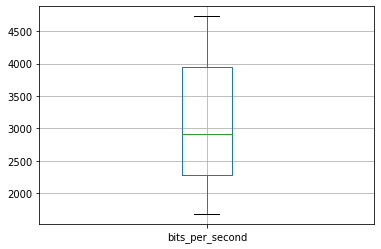

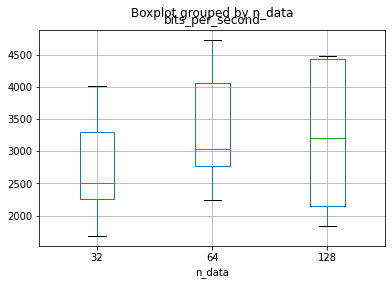

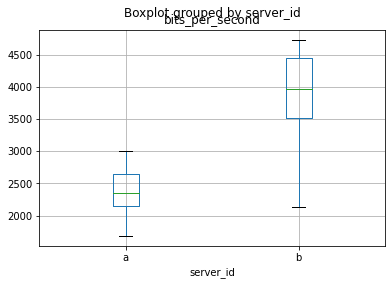

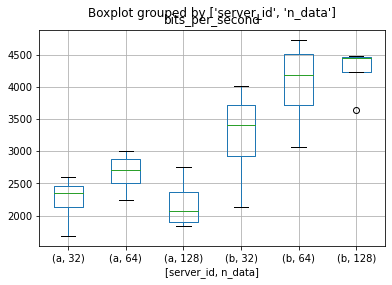

In [6]:
rates_df.boxplot("bits_per_second")
plt.show()
rates_df.boxplot("bits_per_second", by="n_data")
plt.show()
rates_df.boxplot("bits_per_second", by="server_id")
plt.show()
rates_df.boxplot("bits_per_second", by=["server_id","n_data"])
plt.show()

Across all of the benchmarks, the average processing rate is 3000 bits per second. This rate is roughly consistent as we vary the number of rows and the number of bits. This model does not take into account Spark overhead in wrapping libprio functions.

One aspect of variance in processing time can be explained by memory pressure on the Spark worker. The larger payloads for first party server limit the number of rows that can be held in memory. This would materialize as the overhead in disk spill from JVM memory, and in the limited number of rows during Arrow serialization between the JVM and Python. This is supported by the second plot, which shows a higher throughput of server B (the partner) over server A. The partner server receives much smaller (and fixed-sized) shares than the first party.

The last plot suggests some inefficiencies when processing smaller datasets on server B. This may be due to parallelization constraints. There may not be enough work to be assigned to each worker since the data-set size is small. When spread over 200 partitions (the Spark default on shuffles), this may cause extra overhead.

### Linear regression of volume to compute time

https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression

In [7]:
asm = VectorAssembler(
    inputCols=["volume"],
    outputCol="features"
)

model = LinearRegression(fitIntercept=False).fit(
    asm.transform(rates)
    .withColumn("label", F.col("run_seconds"))
    .where("server_id = 'a'")
)

In [8]:
model.coefficients, model.intercept

(DenseVector([0.0005]), 0.0)

In [9]:
model.summary.coefficientStandardErrors

[2.0583907234506157e-05]

In [10]:
model.summary.r2, model.summary.rootMeanSquaredError

(0.9810347233432489, 39.572528199437016)

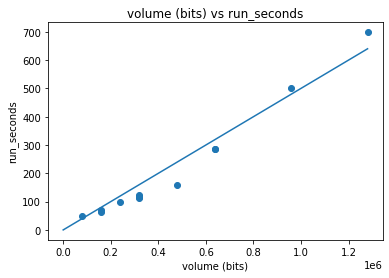

In [11]:
data = rates_df[rates_df.server_id == "a"]
x = np.linspace(0, max(data.volume), 100)
y = 0.0005*x

plt.scatter(data.volume, data.run_seconds)
plt.plot(x, y)
plt.title("volume (bits) vs run_seconds")
plt.xlabel("volume (bits)")
plt.ylabel("run_seconds")
plt.show()

The fit is pretty good. It should be adequate for a rough estimate of cost.

## Estimates

### predictions from linear model

We'll use the linear model trained from the volume of data, alongside the estimate by extrapolating the bits per second rate.

In [12]:
def transform(rows, bits_per_second=1681):
    # default bits_per_second is the lowest rate for server A
    return (
        model.transform(asm.transform(
            spark.createDataFrame(rows)
            .withColumn("volume", F.col("n_rows")*F.col("n_data"))
        ))
        .drop("features")
        .withColumn("hours", F.col("prediction")/3600)
        .withColumn("bps_hours", F.col("volume")/bits_per_second/3600)
        .toPandas().round(1)
    )

In [13]:
transform([
    Row(n_rows=1e6, n_data=32),
    Row(n_rows=1e6, n_data=64),
    Row(n_rows=1e6, n_data=128),    
    Row(n_rows=1e6, n_data=1024),
])

,n_rows,n_data,volume,prediction,hours,bps_hours
0,1000000.0,32,3.200000e+07,15712.2,4.4,5.3
1,1000000.0,64,6.400000e+07,31424.4,8.7,10.6
2,1000000.0,128,1.280000e+08,62848.8,17.5,21.2
3,1000000.0,1024,1.024000e+09,502790.1,139.7,169.2


#### Origin telemetry (day, week, month)

Origin Telemetry encodes the disconnect block list (~2500 origins) sampled from all page loads across Firefox with an expected sample size of 1m documents a week. Blocklist exceptions are recorded into a separate vector.

In [14]:
transform([
    Row(n_rows=2/7*1e6, n_data=2500),
    Row(n_rows=2*1e6*2, n_data=2500),
    Row(n_rows=2*4*1e6, n_data=2500),
])

,n_rows,n_data,volume,prediction,hours,bps_hours
0,285714.3,2500,7.142857e+08,350718.5,97.4,118.0
1,4000000.0,2500,1.000000e+10,4910059.5,1363.9,1652.5
2,8000000.0,2500,2.000000e+10,9820119.0,2727.8,3304.9
